In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

### First test case


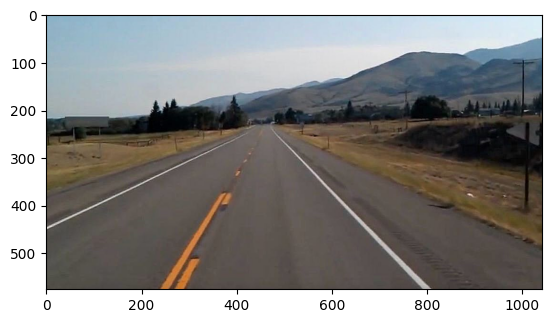

In [4]:
img = cv2.imread("road.jpeg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [5]:
img.shape

(576, 1042, 3)

# Smoothing


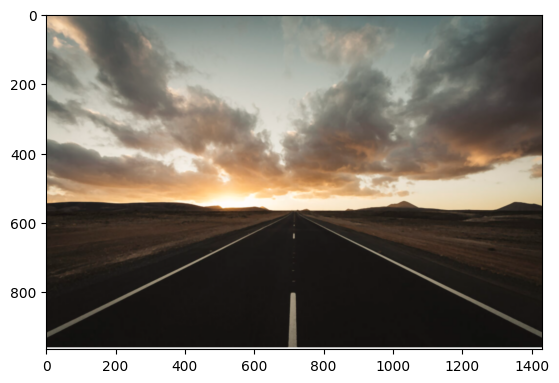

In [35]:
img_smooth = cv2.medianBlur(img, 5)
plt.imshow(cv2.cvtColor(img_smooth, cv2.COLOR_BGR2RGB))

> Smoothing to Reduce unwanted noise

# Edge Detection


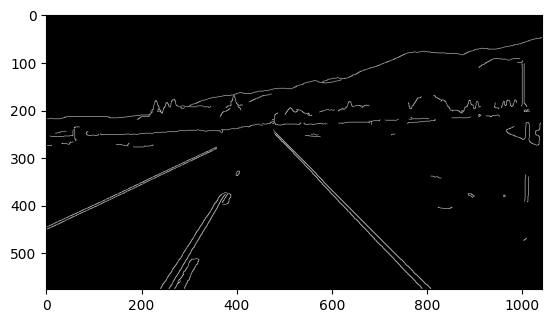

In [7]:
edges = cv2.Canny(img_smooth, 100, 200)
plt.imshow(edges, cmap='gray')

> Edge detection for highlighting lane boundaries

# Region of Interest


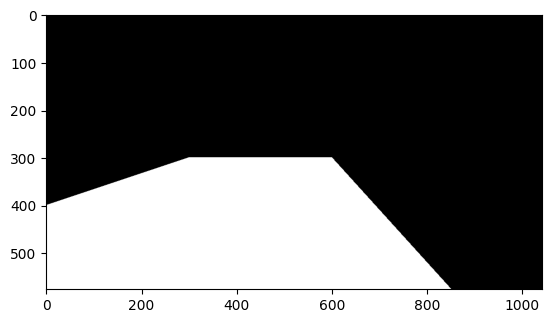

In [8]:
mask = np.zeros(img.shape[:2], dtype=np.uint8)

points = np.array([[0, 400], [300, 300], [600, 300],
                  [850, 576], [0, 576]], np.int32)
# points = np.array([[0, 900], [0, 800], [660, 650], [1150, 650], [1600, 800], [1600, 900]], np.int32)
# points = np.array([[0, 470], [300, 350], [650, 350], [960, 480], [960, 640], [0, 640]], np.int32)

cv2.fillPoly(mask, [points], color=(255, 255, 255))
plt.imshow(mask, cmap='gray')

> isolate the relevant road part of the image

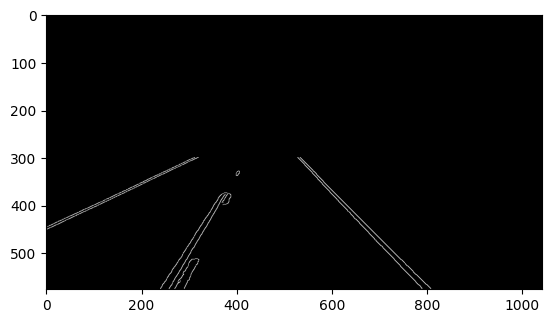

In [9]:
roi = cv2.bitwise_and(mask, edges)
plt.imshow(roi, cmap='gray')

# Accumulation


In [10]:
rho_max = int(np.sqrt(img.shape[0] ** 2 + img.shape[1] ** 2))
theta_max = 180

H = np.zeros([2 * rho_max, theta_max])

In [11]:
for i in range(0, roi.shape[0]):
    for j in range(0, roi.shape[1]):
        if roi[i, j] != 0:
            for theta in range(0, theta_max):
                rho = int(j * np.cos(np.radians(theta)) +
                          i * np.sin(np.radians(theta)))
                rho_index = rho + rho_max
                H[rho_index, theta] += 1

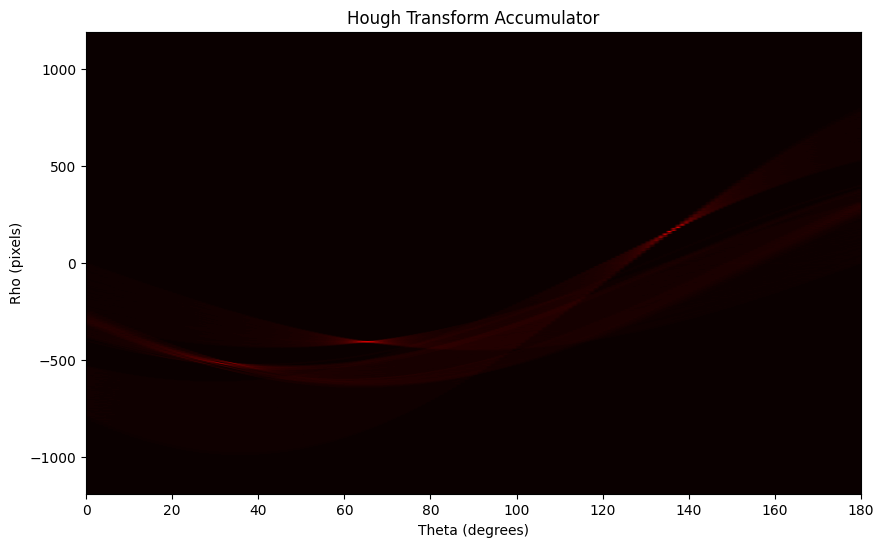

In [12]:
plt.figure(figsize=(10, 6))
plt.imshow(H, cmap='hot', aspect='auto', extent=[0, 180, -rho_max, rho_max])
plt.xlabel("Theta (degrees)")
plt.ylabel("Rho (pixels)")
plt.title("Hough Transform Accumulator")
plt.show()

# Non-max Suppression


In [13]:
def non_max_suppression(H, neighborhood_size=35):
    suppressed_H = np.copy(H)

    for rho in range(H.shape[0]):
        for theta in range(H.shape[1]):
            r_min = max(rho - neighborhood_size // 2, 0)
            r_max = min(rho + neighborhood_size // 2 + 1, H.shape[0])
            t_min = max(theta - neighborhood_size // 2, 0)
            t_max = min(theta + neighborhood_size // 2 + 1, H.shape[1])

            # Get local max value
            local_max = np.max(H[r_min:r_max, t_min:t_max])

            # Suppress non-maximum values
            if H[rho, theta] < local_max:
                suppressed_H[rho, theta] = 0  # Suppress lower peaks

    return suppressed_H

> removeing weaker or redundant lines, keeping only the most prominent lane candidates by tuning neigboorhood size

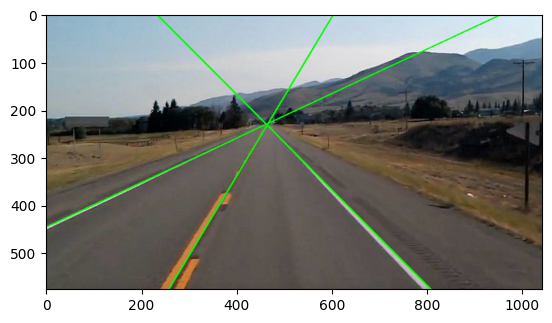

In [14]:
H_suppressed = non_max_suppression(H)

# Threshold to filter weak detections
rho_theta_peaks = np.argwhere(H_suppressed > 50)

final_img = img.copy()

# Draw detected lines on the image
for rho, theta in rho_theta_peaks:
    rho -= rho_max  
    theta = np.radians(theta)
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    cv2.line(final_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))

### second test case


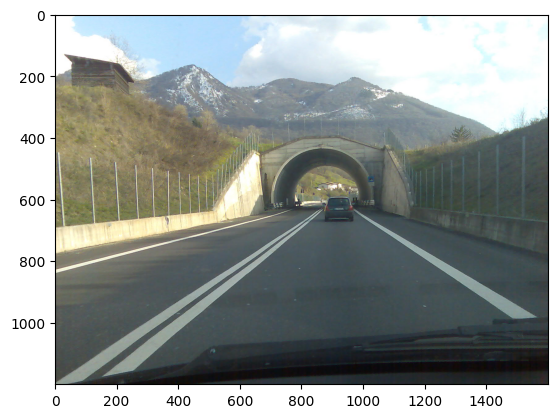

In [15]:
img = cv2.imread("road2.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [16]:
img.shape

(1200, 1600, 3)

### smoothing


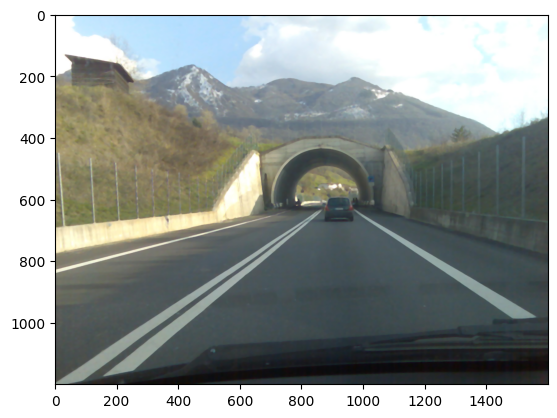

In [17]:
img_smooth = cv2.medianBlur(img, 7)
plt.imshow(cv2.cvtColor(img_smooth, cv2.COLOR_BGR2RGB))

### edge detection


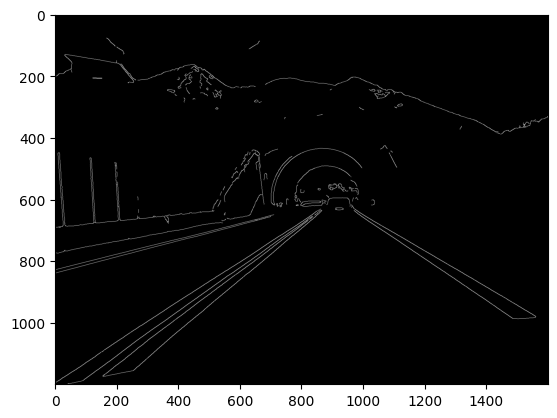

In [18]:
edges = cv2.Canny(img_smooth, 100, 200)
plt.imshow(edges, cmap='gray')

### MasRegion of intreset


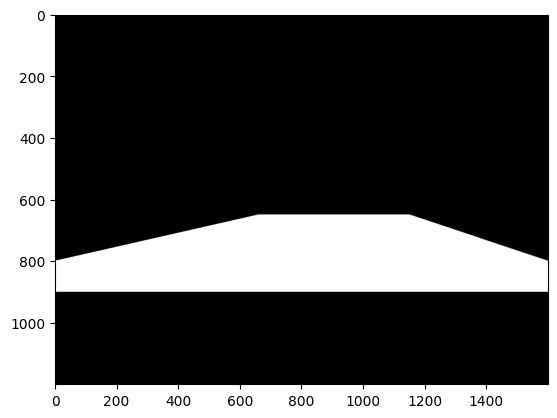

In [19]:
mask = np.zeros(img.shape[:2], dtype=np.uint8)
points = np.array([[0, 900], [0, 800], [660, 650], [1150, 650], [
                  1600, 800], [1600, 900]], np.int32)
cv2.fillPoly(mask, [points], color=(255, 255, 255))
plt.imshow(mask, cmap='gray')

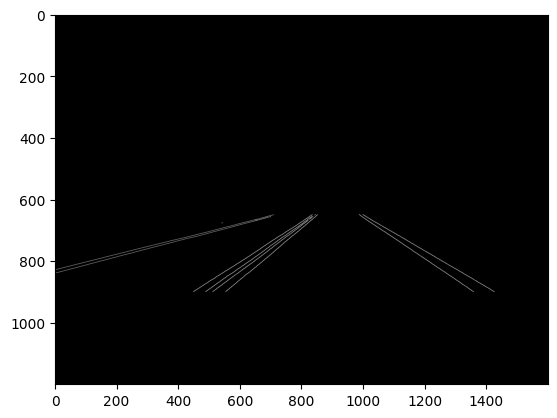

In [20]:
roi = cv2.bitwise_and(mask, edges)
plt.imshow(roi, cmap='gray')

In [21]:
rho_max = int(np.sqrt(img.shape[0] ** 2 + img.shape[1] ** 2))
theta_max = 180

H = np.zeros([2 * rho_max, theta_max])

In [22]:
for i in range(0, roi.shape[0]):
    for j in range(0, roi.shape[1]):
        if roi[i, j] != 0:
            for theta in range(0, theta_max):
                rho = int(j * np.cos(np.radians(theta)) +
                          i * np.sin(np.radians(theta)))
                rho_index = rho + rho_max
                H[rho_index, theta] += 1

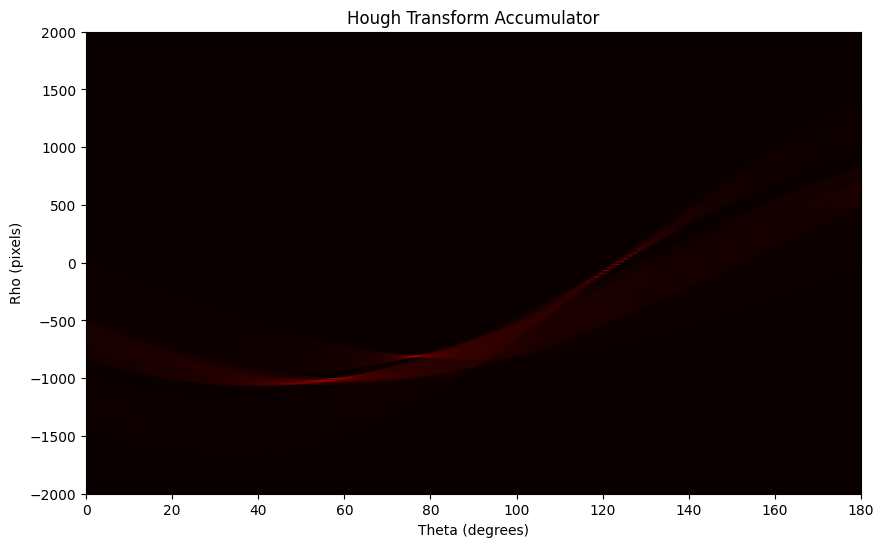

In [23]:
plt.figure(figsize=(10, 6))
plt.imshow(H, cmap='hot', aspect='auto', extent=[0, 180, -rho_max, rho_max])
plt.xlabel("Theta (degrees)")
plt.ylabel("Rho (pixels)")
plt.title("Hough Transform Accumulator")
plt.show()

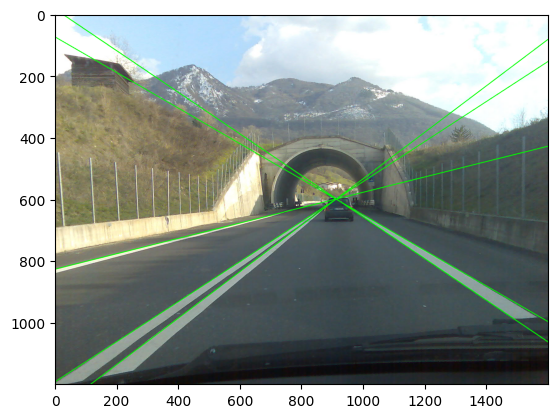

In [24]:
H_suppressed = non_max_suppression(H, neighborhood_size=50)

# Threshold to filter weak detections
rho_theta_peaks = np.argwhere(H_suppressed > 100)

final_img = img.copy()

# Draw detected lines on the image
for rho, theta in rho_theta_peaks:
    rho -= rho_max  # Convert back to original rho range
    theta = np.radians(theta)  # Convert theta back to radians
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 2000 * (-b))
    y1 = int(y0 + 2000 * (a))
    x2 = int(x0 - 2000 * (-b))
    y2 = int(y0 - 2000 * (a))
    cv2.line(final_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))

### Third test case


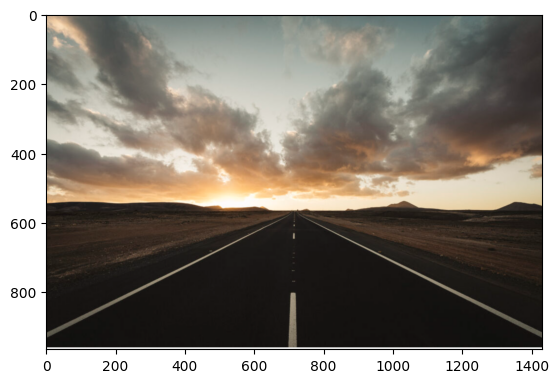

In [25]:
img = cv2.imread('road3.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [26]:
img.shape

(965, 1431, 3)

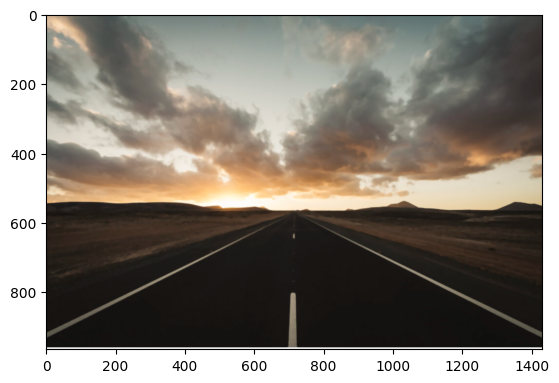

In [27]:
img_smooth = cv2.medianBlur(img, 7)
plt.imshow(cv2.cvtColor(img_smooth, cv2.COLOR_BGR2RGB))

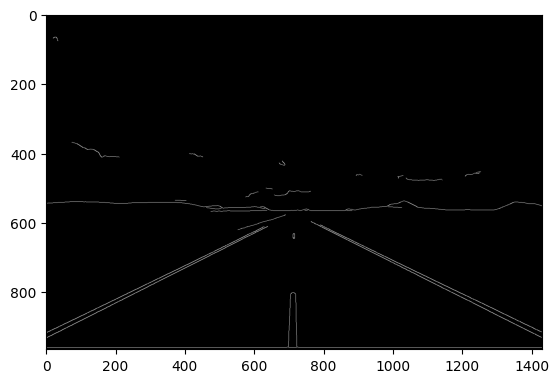

In [28]:
edges = cv2.Canny(img_smooth, 100, 200)
plt.imshow(edges, cmap='gray')

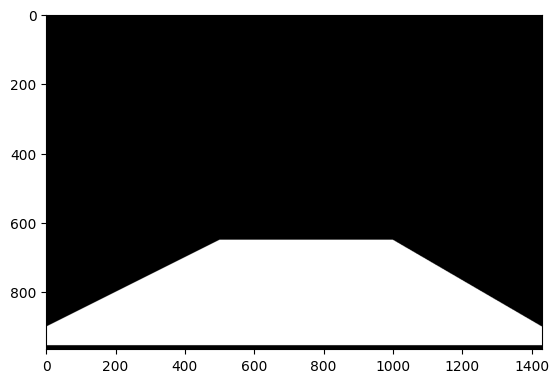

In [29]:
mask = np.zeros(img.shape[:2], dtype=np.uint8)
points = np.array([[0, 953], [0, 900], [500, 650], [1000, 650], [
                  1431, 900], [1431, 953]], np.int32)
cv2.fillPoly(mask, [points], color=(255, 255, 255))
plt.imshow(mask, cmap='gray')

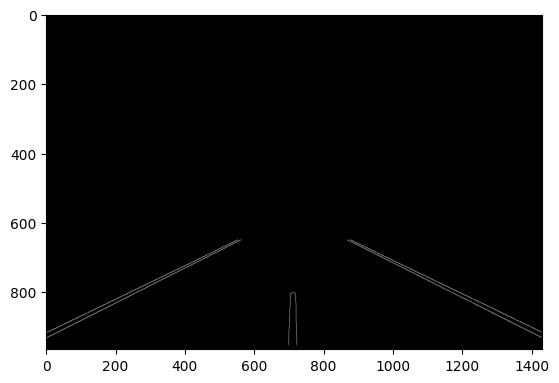

In [30]:
roi = cv2.bitwise_and(mask, edges)
plt.imshow(roi, cmap='gray')

In [31]:
rho_max = int(np.sqrt(img.shape[0] ** 2 + img.shape[1] ** 2))
theta_max = 180

H = np.zeros([2 * rho_max, theta_max])

In [32]:
for i in range(0, roi.shape[0]):
    for j in range(0, roi.shape[1]):
        if roi[i, j] != 0:
            for theta in range(0, theta_max):
                rho = int(j * np.cos(np.radians(theta)) +
                          i * np.sin(np.radians(theta)))
                rho_index = rho + rho_max
                H[rho_index, theta] += 1

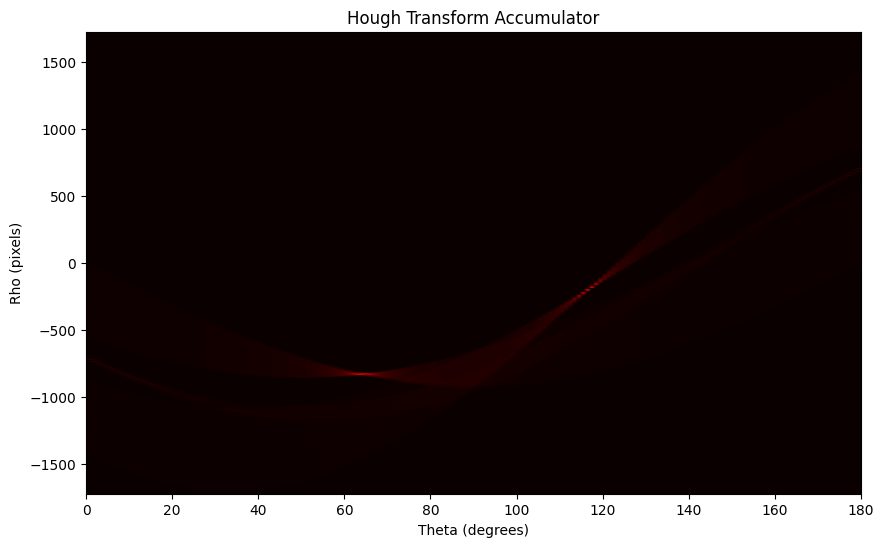

In [33]:
plt.figure(figsize=(10, 6))
plt.imshow(H, cmap='hot', aspect='auto', extent=[0, 180, -rho_max, rho_max])
plt.xlabel("Theta (degrees)")
plt.ylabel("Rho (pixels)")
plt.title("Hough Transform Accumulator")
plt.show()

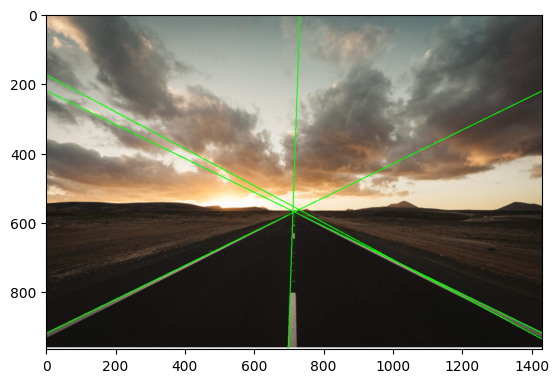

In [34]:
H_suppressed = non_max_suppression(H, neighborhood_size=50)

# Threshold to filter weak detections
rho_theta_peaks = np.argwhere(H_suppressed > 100)

final_img = img.copy()

# Draw detected lines on the image
for rho, theta in rho_theta_peaks:
    rho -= rho_max  # Convert back to original rho range
    theta = np.radians(theta)  # Convert theta back to radians
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 2000 * (-b))
    y1 = int(y0 + 2000 * (a))
    x2 = int(x0 - 2000 * (-b))
    y2 = int(y0 - 2000 * (a))
    cv2.line(final_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))